Prototyping of the case of perspective warping of an image based on a sheet of A4 paper.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import os
import sys
from matplotlib import pyplot as plt

In [3]:
CODE_DIR = os.environ['CODEROOT']
for lib_name in ('visionfuncs', ):
    lib_path = os.path.join(CODE_DIR, lib_name)
    if lib_path not in sys.path:
        sys.path.append(lib_path)

In [4]:
from visionfuncs import io
from visionfuncs import improc
from visionfuncs import corners
from visionfuncs import regions
from visionfuncs import lines
from visionfuncs import geometry
from visionfuncs import viz

In [5]:
from helpers import imshow, show_channels

In [6]:
im_apples = io.open_image('apples_a4.jpg', cv2.IMREAD_COLOR, cv2.COLOR_BGR2RGB)

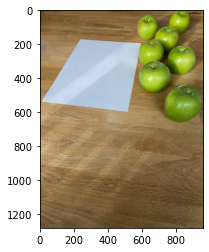

In [7]:
plt.imshow(im_apples)
plt.show()

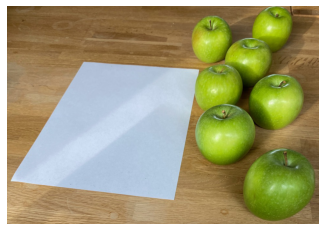

In [8]:
im_cropped = im_apples[:670, :]

imshow(im_cropped)

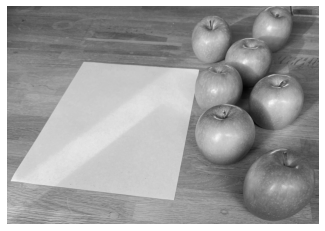

In [9]:
im_gray = cv2.cvtColor(im_cropped, cv2.COLOR_RGB2GRAY)

imshow(im_gray, cmap='gray')

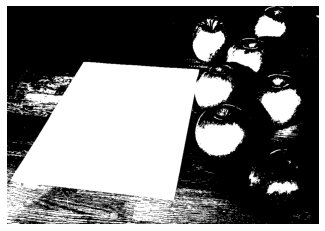

In [10]:
imshow(im_gray >= 150, cmap='gray')

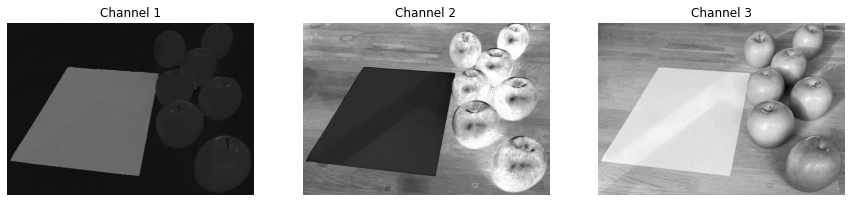

In [11]:
im_hsv = cv2.cvtColor(im_cropped, cv2.COLOR_RGB2HSV)

show_channels(im_hsv)

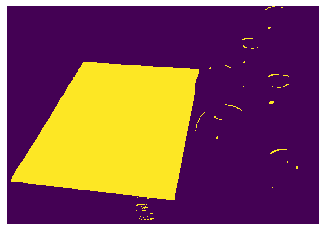

In [12]:
im_sat_thresh = regions.threshold_binary_inv(im_hsv[:, :, 1], 70)

imshow(im_sat_thresh, interpolation='none')

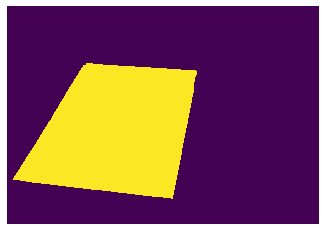

In [13]:
im_eroded = improc.erode(im_sat_thresh, kernel_size=9, n_iter=1)

imshow(im_eroded, interpolation='none')

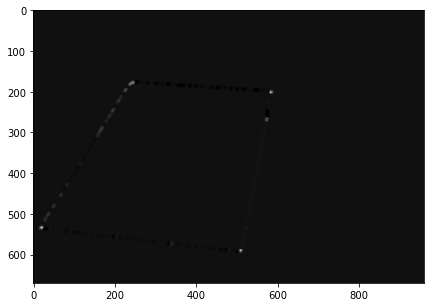

In [14]:
im_corners = corners.harris(im_eroded, block_size=10, ksize=3, k=0.04)

plt.figure(figsize=(7, 9))
plt.imshow(im_corners, cmap='gray')
plt.show()

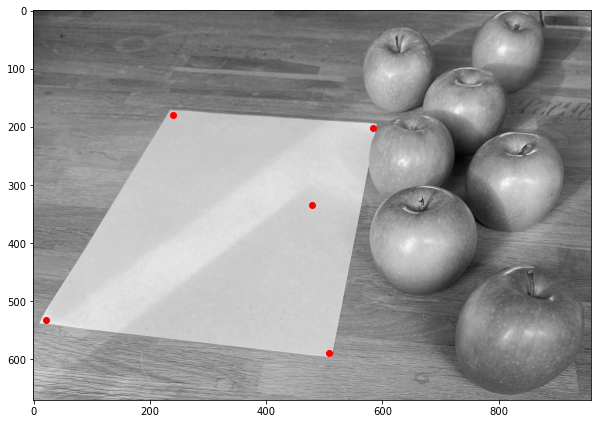

In [15]:
corner_coords = corners.harris_centroids(im_corners, 0.5)

plt.figure(figsize=(10, 15))
plt.imshow(im_gray, cmap='gray')

plt.scatter(corner_coords[:, 0], corner_coords[:, 1], color='red')

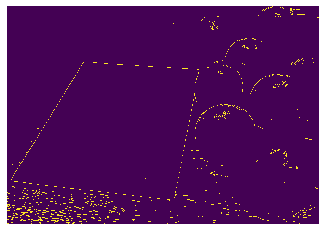

In [16]:
im_edges = cv2.Canny(im_gray, 150, 200)

imshow(im_edges, interpolation='none')

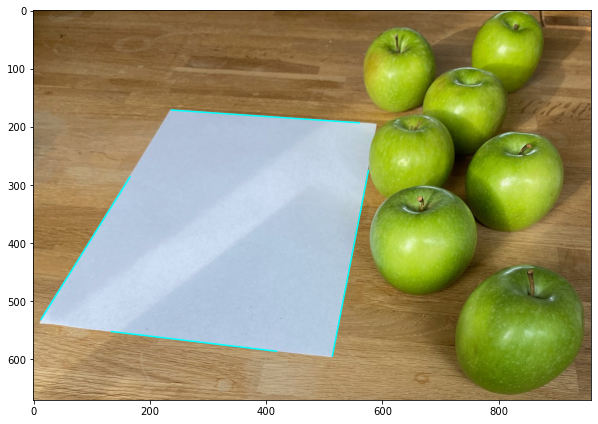

In [17]:
paper_lines = lines.hough_lines(im_edges, 1, np.pi/180, 150, 200, 10)

plt.figure(figsize=(10, 15))
_ = plt.imshow(im_cropped)

for line in paper_lines:
    viz.plot_line(line, color='cyan')

In [18]:
paper_lines

array([[ 13, 531, 166, 286],
       [237, 171, 560, 193],
       [514, 594, 576, 275],
       [134, 552, 418, 586]], dtype=int32)

In [19]:
line_vecs = lines.opencv_points_to_line_vectors(paper_lines)

line_vecs

array([[-2.90188089e-03, -1.81219501e-03,  1.00000000e+00],
       [ 4.39832864e-04, -6.45754613e-03,  1.00000000e+00],
       [-1.58869289e-03, -3.08774167e-04,  1.00000000e+00],
       [ 2.23372664e-04, -1.86581873e-03,  1.00000000e+00]])

In [20]:
def corners_from_lines(opencv_lines):
    
    n_lines = len(opencv_lines)
    
    line_vecs = lines.opencv_points_to_line_vectors(opencv_lines)
    
    res = []
    
    for i in range(n_lines):
        for j in range(i + 1, n_lines):
            
            line_i = line_vecs[i]
            line_j = line_vecs[j]
            
            p_homog = np.cross(line_i, line_j)
            p = geometry.h2e(p_homog)
            
            if p[0] >= 0 and p[1] >= 0:
                res.append(p)
                
    return np.array(res)

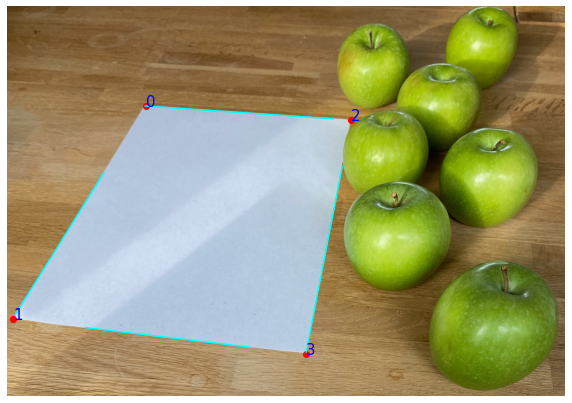

In [21]:
cfl = corners_from_lines(paper_lines)

plt.figure(figsize=(10, 15))
plt.imshow(im_cropped)
plt.axis('off')

for line in paper_lines:
    viz.plot_line(line, color='cyan')
    
plt.scatter(cfl[:, 0], cfl[:, 1], color='red')

ax = plt.gca()

for i, coord in enumerate(cfl):
    ax.annotate(i, coord, color='blue', size=15)

plt.show()

Dimension of an A4 paper: 210 x 297 mm

In [22]:
def create_rectangle_points(origin, width, height):
    
    x, y = origin
    
    points = np.array(
        [
            [x, y],
            [x+width, y],
            [x+width, y+height],
            [x, y+height],
        ], 
        dtype=np.float32
    )

    return points

In [23]:
dst_points = create_rectangle_points(origin=(10, 300), width=210, height=297)

dst_points

array([[ 10., 300.],
       [220., 300.],
       [220., 597.],
       [ 10., 597.]], dtype=float32)

In [24]:
src_points = np.array(
    [
        cfl[0],
        cfl[2],
        cfl[3],
        cfl[1]
    ],
    dtype=np.float32
)

In [25]:
M = cv2.getPerspectiveTransform(src_points, dst_points)

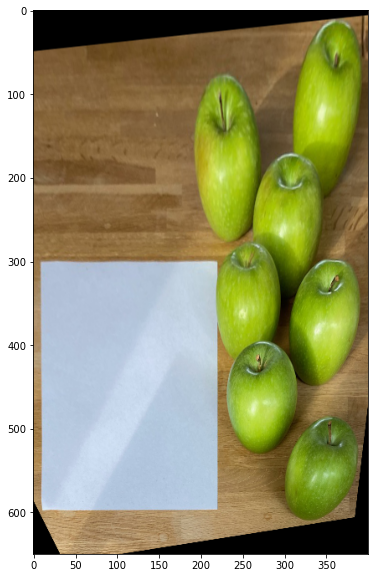

In [26]:
im_warped = cv2.warpPerspective(im_cropped, M, (400, 650), flags=cv2.INTER_LINEAR)

plt.figure(figsize=(10, 10))
plt.imshow(im_warped)
plt.show()